In [25]:
###### DON'T USE IT, CRASHES AFTER RUNNING FOR MORE THAN AN HOUR

# from datasets import load_dataset

# # Login using e.g. `huggingface-cli login` to access this dataset
# ds = load_dataset("AisotTechnologies/aisot_btc_lob_trades")

In [26]:
###### USE THIS METHOD INSTEAD

# from huggingface_hub import snapshot_download

# snapshot_download(repo_id="AisotTechnologies/aisot_btc_lob_trades", allow_patterns="*.zip", local_dir='data/', repo_type='dataset')

In [27]:
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
sys.path.append(str(Path().resolve().parent))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import *
import os

import os
from pathlib import Path
import pandas as pd
from datasets import load_dataset  # Assuming this is from the 'datasets' library

import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
from datasets import load_dataset
import warnings

import os
from pathlib import Path
import pandas as pd
from datasets import load_dataset  # Assuming this is from the 'datasets' library
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
from datasets import load_dataset
import warnings

import os
from pathlib import Path
import pandas as pd
from datasets import load_dataset  # Assuming this is from the 'datasets' library
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

from funcs.data_read import (
    read_txn_data,  
    read_ob_data,
    load_ob_features,
    load_trx_features,
)

from funcs.preprocess import (
    preprocess_ob_data, 
    preprocess_trx_data,
)

from funcs.features import (
    create_features_order_book,
    create_features_trx,
)

from funcs.utils import (
    filter_extremes,
    deseason_total_volume,
)






In [29]:
trx_1min_features = load_trx_features("1min")
ob_1min_fatures=load_ob_features(freq="1min")

✅ Loaded TRX features (1min) from:
C:\Users\peter\codes\ml\eth\Komplex\trx_features\trx_features_1min.parquet
Reading 109 files from C:\Users\peter\codes\ml\eth\Komplex\ob_features\1min...
Combined DataFrame for 1min created. Total rows: 155,954


In [30]:
# Merge the two DataFrames on "timestamp_id" ,max diff is 1  min
 
# Ensure both DataFrames have the same timestamp format
trx_1min_features['timestamp_id'] = pd.to_datetime(trx_1min_features['timestamp_id'])
ob_1min_fatures['timestamp_id'] = pd.to_datetime(ob_1min_fatures['timestamp_id'])

# Merge the DataFrames on "timestamp_id" with a tolerance of 2 minutes
merged_df = pd.merge_asof(
    trx_1min_features.sort_values("timestamp_id"),
    ob_1min_fatures.sort_values("timestamp_id"),
    on="timestamp_id",
    direction="nearest",
    tolerance=pd.Timedelta("2min")
)

# Check the result of the merge
print(f"Merged DataFrame created. Total rows: {len(merged_df):,}")


#rename datatime_x to datatime
merged_df.rename(columns={"timestamp_id_x": "timestamp_id"}, inplace=True)
merged_df.rename(columns={"datetime_x": "datetime"}, inplace=True)
print(merged_df)

Merged DataFrame created. Total rows: 168,743
                        timestamp_id                  datetime  first_price  \
0      1970-01-01 00:00:01.527800400 2018-05-31 21:00:00+00:00      7538.34   
1      1970-01-01 00:00:01.527800460 2018-05-31 21:01:00+00:00      7532.43   
2      1970-01-01 00:00:01.527800520 2018-05-31 21:02:00+00:00      7535.01   
3      1970-01-01 00:00:01.527800580 2018-05-31 21:03:00+00:00      7540.19   
4      1970-01-01 00:00:01.527800640 2018-05-31 21:04:00+00:00      7541.00   
...                              ...                       ...          ...   
168738 1970-01-01 00:00:01.538344500 2018-09-30 21:55:00+00:00      6553.46   
168739 1970-01-01 00:00:01.538344560 2018-09-30 21:56:00+00:00      6555.77   
168740 1970-01-01 00:00:01.538344620 2018-09-30 21:57:00+00:00      6555.75   
168741 1970-01-01 00:00:01.538344680 2018-09-30 21:58:00+00:00      6555.00   
168742 1970-01-01 00:00:01.538344740 2018-09-30 21:59:00+00:00      6555.73   

     

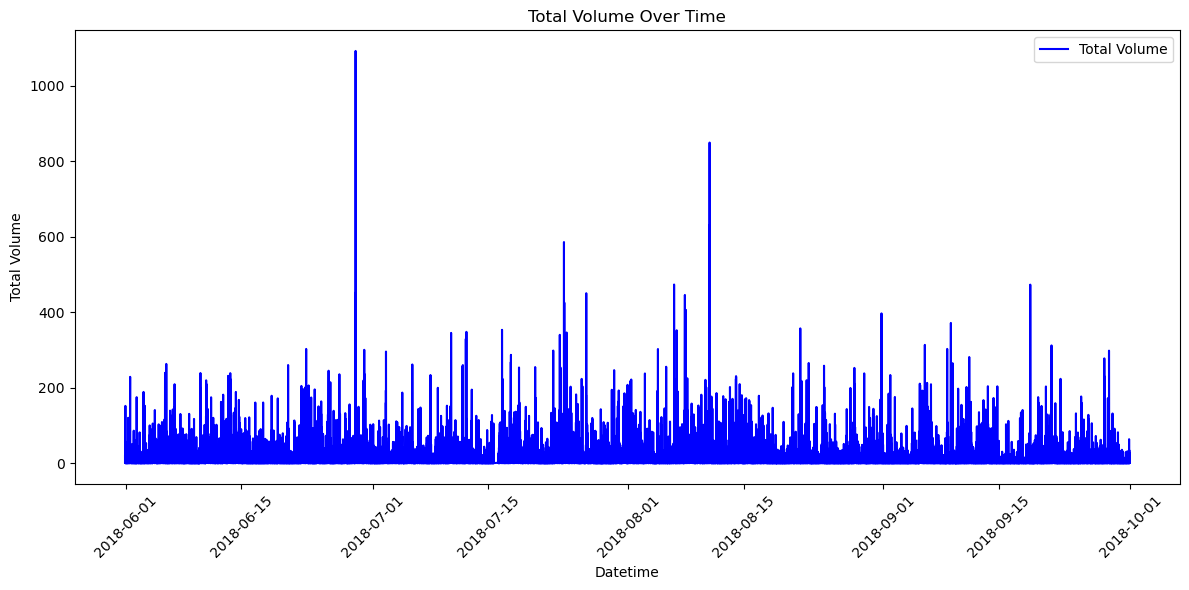

In [51]:
# plot total volume 

plt.figure(figsize=(12, 6))
plt.plot(merged_df["datetime"], merged_df["total_volume"], label="Total Volume", color='blue')
plt.title("Total Volume Over Time")
plt.xlabel("Datetime")
plt.ylabel("Total Volume")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

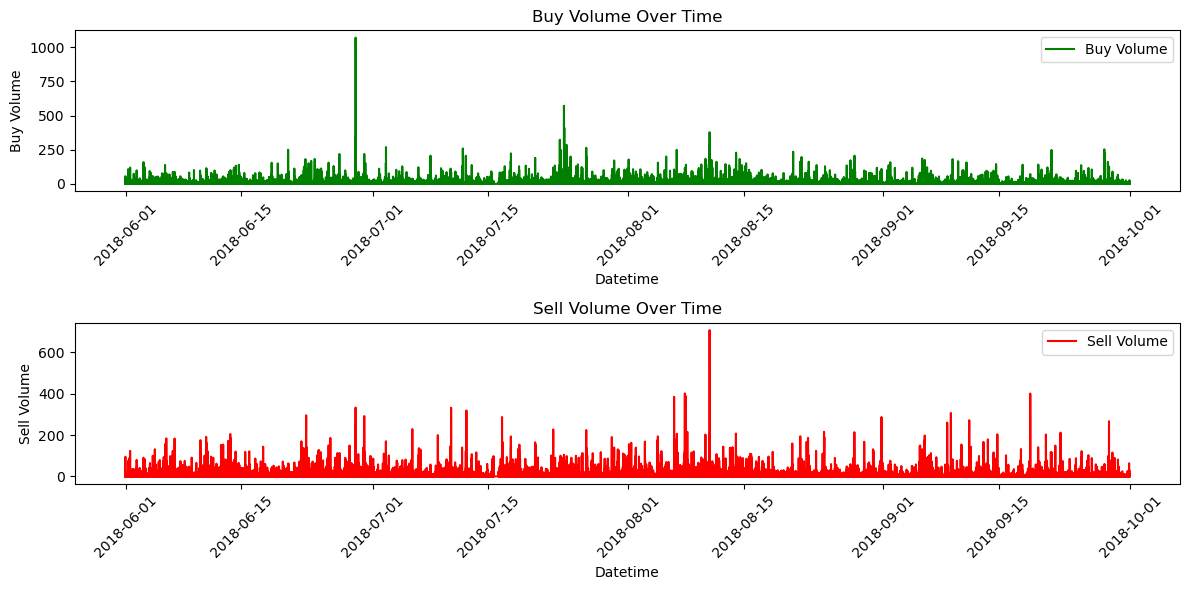

In [53]:
# buy and sell volume on two plot under one another
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(merged_df["datetime"], merged_df["buy_volume"], label="Buy Volume", color='green')
plt.title("Buy Volume Over Time")
plt.xlabel("Datetime")
plt.ylabel("Buy Volume")
plt.xticks(rotation=45)

plt.legend()
plt.subplot(2, 1, 2)
plt.plot(merged_df["datetime"], merged_df["sell_volume"], label="Sell Volume", color='red')
plt.title("Sell Volume Over Time")
plt.xlabel("Datetime")
plt.ylabel("Sell Volume")
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# date of the man and min sell volume

max_sell_volume_date = merged_df.loc[merged_df['sell_volume'].idxmax(), 'datetime']
min_sell_volume_date = merged_df.loc[merged_df['sell_volume'].idxmin(), 'datetime']
print(f"Max Sell Volume Date: {max_sell_volume_date}")
print(f"Min Sell Volume Date: {min_sell_volume_date}")

# same for buy volume
max_buy_volume_date = merged_df.loc[merged_df['buy_volume'].idxmax(), 'datetime']
min_buy_volume_date = merged_df.loc[merged_df['buy_volume'].idxmin(), 'datetime']
print(f"Max Buy Volume Date: {max_buy_volume_date}")
print(f"Min Buy Volume Date: {min_buy_volume_date}")    

Max Sell Volume Date: 2018-08-10 21:08:00+00:00
Min Sell Volume Date: 2018-05-31 21:04:00+00:00
Max Buy Volume Date: 2018-06-28 21:10:00+00:00
Min Buy Volume Date: 2018-06-01 02:50:00+00:00


In [54]:
trx_dataset_grouped=merged_df.copy()

### Stackplot

In [32]:
# Add time column for grouping
trx_dataset_grouped['time'] = trx_dataset_grouped['datetime'].dt.time

# Group by time and calculate quantiles
trx_dataset_grouped_viz = trx_dataset_grouped.groupby("time")['total_volume'].quantile([0.25, 0.5, 0.75]).unstack()
trx_dataset_grouped_viz.rename({0.25: 'Q1', 0.5: 'Q2', 0.75: 'Q3'}, axis=1, inplace=True)

# Calculate IQR ranges
trx_dataset_grouped_viz['Q1_Q2'] = trx_dataset_grouped_viz['Q2'] - trx_dataset_grouped_viz['Q1']  # Lower IQR
trx_dataset_grouped_viz['Q2_Q3'] = trx_dataset_grouped_viz['Q3'] - trx_dataset_grouped_viz['Q2']  # Upper IQR

# Convert time index to minutes since midnight for plotting
trx_dataset_grouped_viz['minutes_since_midnight'] = [t.hour * 60 + t.minute for t in trx_dataset_grouped_viz.index]

# Display the first few rows
print(trx_dataset_grouped_viz.head())

                Q1        Q2        Q3     Q1_Q2     Q2_Q3  \
time                                                         
00:00:00  0.465289  2.190750  7.687681  1.725461  5.496931   
00:01:00  0.701499  2.722075  6.400917  2.020576  3.678842   
00:02:00  0.394041  1.337212  6.419471  0.943171  5.082259   
00:03:00  0.533070  2.137138  6.240888  1.604068  4.103750   
00:04:00  0.308838  2.446320  5.799946  2.137483  3.353626   

          minutes_since_midnight  
time                              
00:00:00                       0  
00:01:00                       1  
00:02:00                       2  
00:03:00                       3  
00:04:00                       4  


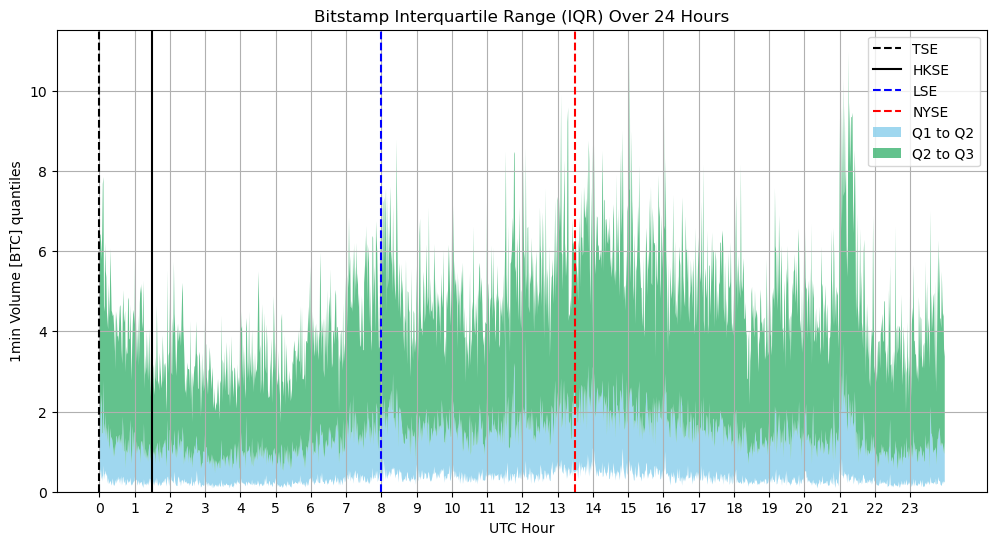

In [33]:
# Calculate IQR ranges


# Plot
fig, ax = plt.subplots(figsize=(12, 6))

minutes = [0, 90, 480, 810]  # Convert times to minutes since midnight

colors = ['black', 'black', 'blue', 'red']
labels = ['TSE', 'HKSE', 'LSE', 'NYSE']
for t, color, label in zip(minutes, colors, labels):
    if label == 'HKSE':
        ax.axvline(x=t, color=color, label=label)
    else:   
        ax.axvline(x=t, linestyle='--', color=color, label=label)

ax.stackplot(trx_dataset_grouped_viz['minutes_since_midnight'], trx_dataset_grouped_viz['Q1'], trx_dataset_grouped_viz['Q1_Q2'], trx_dataset_grouped_viz['Q2_Q3'], 
             labels=["", "Q1 to Q2", "Q2 to Q3"], colors=['none','skyblue', 'mediumseagreen'], edgecolor='none', alpha=0.8)

# Formatting X-axis to show only hours
ax.set_xticks(np.arange(0, 1381, 60))  # Tick every 60 minutes (every hour)
ax.set_xticklabels(range(0, 24))  # Labels from 0 to 23 (only hours)

# Labels and title
ax.set_xlabel("UTC Hour")
ax.set_ylabel("1min Volume [BTC] quantiles")
ax.set_title("Bitstamp Interquartile Range (IQR) Over 24 Hours")
ax.legend()
ax.grid(True)

plt.show()

### Distribution plot

In [34]:
trx_dataset_grouped['deseasoned_total_volume']=trx_dataset_grouped['total_volume']

In [35]:
print(f"minimal volume after 0 is {trx_dataset_grouped.loc[trx_dataset_grouped['deseasoned_total_volume'] >0]['deseasoned_total_volume'].min()} BTC")
print("!!!!! It is an open question how much to adjust the zero values to be inserted in the logarithm function. For now I choose 1e-7")

minimal volume after 0 is 8.6e-07 BTC
!!!!! It is an open question how much to adjust the zero values to be inserted in the logarithm function. For now I choose 1e-7


In [36]:
trx_dataset_grouped['log_deseasoned_total_volume'] = np.log(trx_dataset_grouped['deseasoned_total_volume'] + 1e-7)

In [37]:
trx_dataset_grouped['log_deseasoned_total_volume']
#dropna
trx_dataset_grouped = trx_dataset_grouped.dropna()
trx_dataset_grouped["deseasoned_total_volume"].isna().sum()

0

In [38]:
trx_dataset_grouped


,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance_x,...,ask_slope_5pct,bid_slope_10pct,bid_slope_1pct,bid_slope_5pct,slope_imbalance_10pct,slope_imbalance_1pct,slope_imbalance_5pct,time,deseasoned_total_volume,log_deseasoned_total_volume
0,1970-01-01 00:00:01.527800400,2018-05-31 21:00:00+00:00,7538.34,7542.01,7544.79,7531.36,18.203291,0.677437,18.880728,17.525854,...,709.102076,1528.213316,249.016349,841.627346,648.362222,92.507778,132.525270,21:00:00,18.880728,2.938142
1,1970-01-01 00:00:01.527800460,2018-05-31 21:01:00+00:00,7532.43,7539.40,7544.69,7530.81,0.218896,0.946981,1.165876,-0.728085,...,709.102076,1528.213316,249.016349,841.627346,648.362222,92.507778,132.525270,21:01:00,1.165876,0.153473
2,1970-01-01 00:00:01.527800520,2018-05-31 21:02:00+00:00,7535.01,7540.11,7540.11,7535.01,0.021258,0.011077,0.032336,0.010181,...,709.102076,1528.213316,249.016349,841.627346,648.362222,92.507778,132.525270,21:02:00,0.032336,-3.431573
3,1970-01-01 00:00:01.527800580,2018-05-31 21:03:00+00:00,7540.19,7540.00,7541.90,7535.01,0.143166,0.001062,0.144229,0.142104,...,709.102076,1528.213316,249.016349,841.627346,648.362222,92.507778,132.525270,21:03:00,0.144229,-1.936355
4,1970-01-01 00:00:01.527800640,2018-05-31 21:04:00+00:00,7541.00,7543.32,7543.32,7538.34,2.837166,0.000000,2.837166,2.837166,...,709.102076,1528.213316,249.016349,841.627346,648.362222,92.507778,132.525270,21:04:00,2.837166,1.042806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168738,1970-01-01 00:00:01.538344500,2018-09-30 21:55:00+00:00,6553.46,6554.33,6555.77,6553.44,1.310116,0.000000,1.310116,1.310116,...,1028.643470,1663.029639,235.813402,704.366480,322.422076,1.195367,324.276990,21:55:00,1.310116,0.270116
168739,1970-01-01 00:00:01.538344560,2018-09-30 21:56:00+00:00,6555.77,6554.20,6555.77,6554.20,0.134624,0.038058,0.172682,0.096565,...,1032.789759,1660.572572,232.846335,700.904624,319.568679,113.368165,331.885135,21:56:00,0.172682,-1.756304
168740,1970-01-01 00:00:01.538344620,2018-09-30 21:57:00+00:00,6555.75,6555.78,6555.79,6554.30,1.491747,0.038143,1.529890,1.453603,...,1028.985155,1660.949665,226.119244,702.255443,325.641642,119.372394,326.729711,21:57:00,1.529890,0.425196
168741,1970-01-01 00:00:01.538344680,2018-09-30 21:58:00+00:00,6555.00,6555.00,6555.76,6555.00,0.010576,0.924569,0.935145,-0.913993,...,1014.151773,1653.246750,224.596329,694.552529,332.772109,120.541927,319.599244,21:58:00,0.935145,-0.067054


DataFrame shape: (168743, 31)
Columns: Index(['timestamp_id', 'datetime', 'first_price', 'last_price', 'max_price',
       'min_price', 'buy_volume', 'sell_volume', 'total_volume',
       'volume_imbalance_x', 'buy_transactions', 'sell_transactions',
       'transaction_imbalance', 'datetime_y', 'mid_price', 'spread',
       'ask_volume', 'bid_volume', 'volume_imbalance_y', 'ask_slope_10pct',
       'ask_slope_1pct', 'ask_slope_5pct', 'bid_slope_10pct', 'bid_slope_1pct',
       'bid_slope_5pct', 'slope_imbalance_10pct', 'slope_imbalance_1pct',
       'slope_imbalance_5pct', 'time', 'deseasoned_total_volume',
       'log_deseasoned_total_volume'],
      dtype='object')
NaN count in log_deseasoned_total_volume: 0
Sample of log_deseasoned_total_volume:
0    2.938142
1    0.153473
2   -3.431573
3   -1.936355
4    1.042806
Name: log_deseasoned_total_volume, dtype: float64


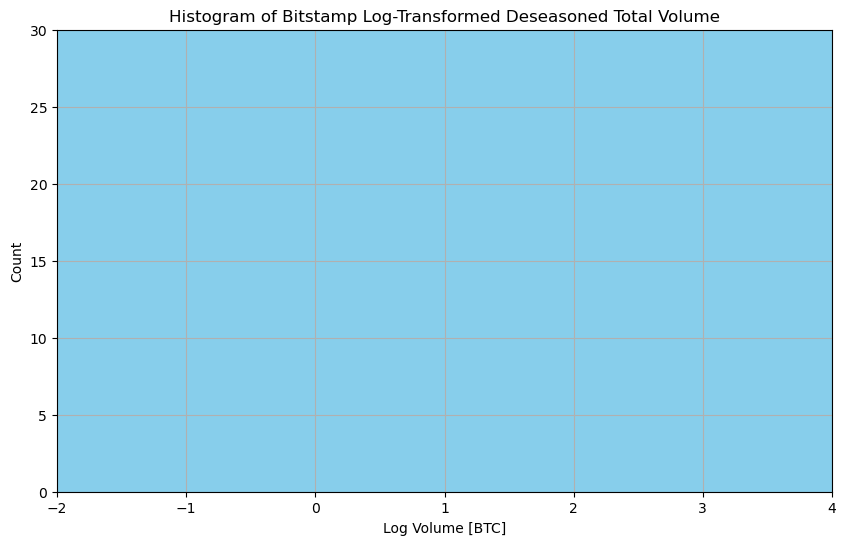

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Verify the DataFrame
print("DataFrame shape:", trx_dataset_grouped.shape)
print("Columns:", trx_dataset_grouped.columns)
print("NaN count in log_deseasoned_total_volume:", trx_dataset_grouped['log_deseasoned_total_volume'].isnull().sum())
print("Sample of log_deseasoned_total_volume:")
print(trx_dataset_grouped['log_deseasoned_total_volume'].head())

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(trx_dataset_grouped['log_deseasoned_total_volume'], bins=300, color='skyblue', edgecolor='none')
plt.xlim(-2, 4)  # Adjusted based on data range (-0.4 to 3.3)
plt.ylim(0, 30)  # Adjusted based on expected frequency with 296 rows
plt.title("Histogram of Bitstamp Log-Transformed Deseasoned Total Volume")
plt.xlabel("Log Volume [BTC]")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [40]:
#create log volume column

trx_dataset_grouped['log_total_volume'] = np.log(trx_dataset_grouped['total_volume'] + 1e-7)

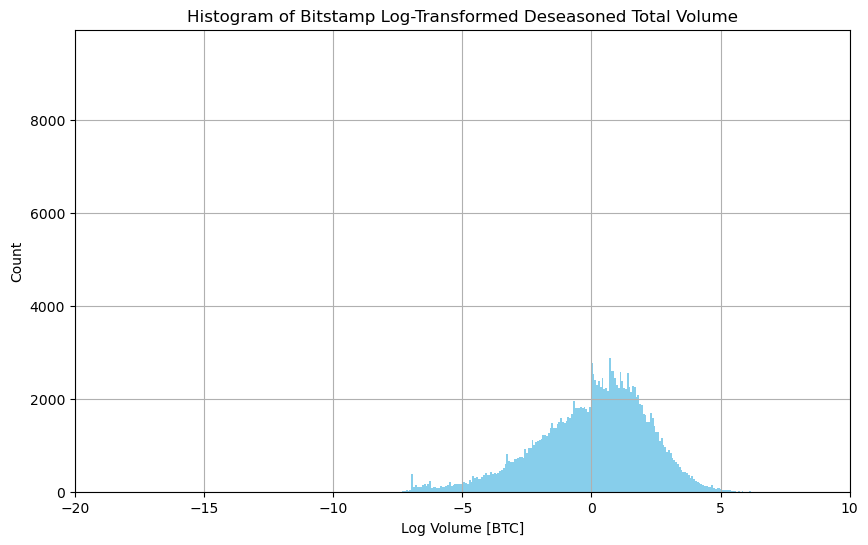

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(trx_dataset_grouped['log_total_volume'], bins=300, color='skyblue', edgecolor='none')
plt.xlim(-20, 10)  # Adjusted based on data range (-0.4 to 3.3)
plt.ylim(0, 9950)  # Adjusted based on expected frequency with 296 rows
plt.title("Histogram of Bitstamp Log-Transformed Deseasoned Total Volume")
plt.xlabel("Log Volume [BTC]")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [42]:
# Calculate mean, variance, skewness, and kurtosis of the 'volume' column
mean_volume = trx_dataset_grouped['log_deseasoned_total_volume'].mean()
variance_volume = trx_dataset_grouped['log_deseasoned_total_volume'].var()
skewness_volume = stats.skew(trx_dataset_grouped['log_deseasoned_total_volume'])
kurtosis_volume = stats.kurtosis(trx_dataset_grouped['log_deseasoned_total_volume'])

# Display the results
print(f"Mean: {mean_volume}")
print(f"Variance: {variance_volume}")
print(f"Skewness: {skewness_volume}")
print(f"Kurtosis: {kurtosis_volume}")

Mean: 0.03402309850561889
Variance: 4.6052553609737945
Skewness: -0.6167279646554705
Kurtosis: 0.42249985600715556


In [43]:
trx_dataset_grouped.head()

,timestamp_id,datetime,first_price,last_price,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance_x,...,bid_slope_10pct,bid_slope_1pct,bid_slope_5pct,slope_imbalance_10pct,slope_imbalance_1pct,slope_imbalance_5pct,time,deseasoned_total_volume,log_deseasoned_total_volume,log_total_volume
0,1970-01-01 00:00:01.527800400,2018-05-31 21:00:00+00:00,7538.34,7542.01,7544.79,7531.36,18.203291,0.677437,18.880728,17.525854,...,1528.213316,249.016349,841.627346,648.362222,92.507778,132.52527,21:00:00,18.880728,2.938142,2.938142
1,1970-01-01 00:00:01.527800460,2018-05-31 21:01:00+00:00,7532.43,7539.40,7544.69,7530.81,0.218896,0.946981,1.165876,-0.728085,...,1528.213316,249.016349,841.627346,648.362222,92.507778,132.52527,21:01:00,1.165876,0.153473,0.153473
2,1970-01-01 00:00:01.527800520,2018-05-31 21:02:00+00:00,7535.01,7540.11,7540.11,7535.01,0.021258,0.011077,0.032336,0.010181,...,1528.213316,249.016349,841.627346,648.362222,92.507778,132.52527,21:02:00,0.032336,-3.431573,-3.431573
3,1970-01-01 00:00:01.527800580,2018-05-31 21:03:00+00:00,7540.19,7540.00,7541.90,7535.01,0.143166,0.001062,0.144229,0.142104,...,1528.213316,249.016349,841.627346,648.362222,92.507778,132.52527,21:03:00,0.144229,-1.936355,-1.936355
4,1970-01-01 00:00:01.527800640,2018-05-31 21:04:00+00:00,7541.00,7543.32,7543.32,7538.34,2.837166,0.000000,2.837166,2.837166,...,1528.213316,249.016349,841.627346,648.362222,92.507778,132.52527,21:04:00,2.837166,1.042806,1.042806


### ACF and PACF

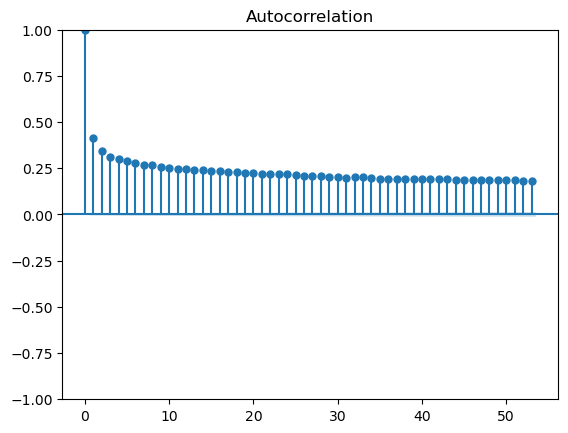

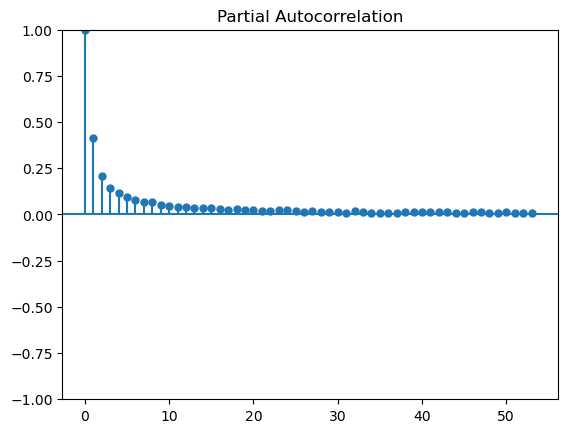

In [44]:
plot_acf(trx_dataset_grouped['log_deseasoned_total_volume']);
plot_pacf(trx_dataset_grouped['log_deseasoned_total_volume']);

### LOB data

#### Example of loading

In [45]:
lob_df = create_lob_dataset(use_load=False)
lob_df.head()

NameError: name 'create_lob_dataset' is not defined

## Playground for future (Irrelevant), You can ignore what's below

In [ ]:
single_file_ob_dataset = ["./data/bitstamp_ob_04_07_2018.zip"]
lob_dataset = load_dataset("csv", data_files=single_file_ob_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
lob_dataset

DatasetDict({
    train: Dataset({
        features: ['time', 'type', 'price', 'amount '],
        num_rows: 24084011
    })
})

In [ ]:
lob_dataset = lob_dataset['train'].to_pandas()
lob_dataset['datetime'] = pd.to_datetime(lob_dataset['time'], unit='s', utc=True)
lob_dataset.drop(['time'], axis=1, inplace = True)
lob_dataset.rename({col:col.strip() for col in lob_dataset.columns}, axis=1, inplace=True)
lob_dataset.head()


,type,price,amount,datetime
0,b,6613.32,0.068823,2018-07-03 22:00:01+00:00
1,b,6613.31,3.709311,2018-07-03 22:00:01+00:00
2,b,6608.79,0.015000,2018-07-03 22:00:01+00:00
3,b,6608.78,1.000000,2018-07-03 22:00:01+00:00
4,b,6608.77,1.911835,2018-07-03 22:00:01+00:00


### Playground for future LOB feature creation

In [ ]:
# Define data
lb_df = {
    'type': ['b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a']*2,
    'price': [100, 101, 102, 103, 104, 105, 107, 108, 109, 110]*2,
    'amount': [10, 5, 8, 10, 17, 15, 12, 8, 12, 33]*2,
    'datetime': pd.to_datetime(['2024-03-04 22:31:01'] * 10 + ['2024-03-04 22:32:01'] * 10)  # Convert to datetime
}

# Create DataFrame
lb_df = pd.DataFrame(lb_df)
lb_df

,type,price,amount,datetime
0,b,100,10,2024-03-04 22:31:01
1,b,101,5,2024-03-04 22:31:01
2,b,102,8,2024-03-04 22:31:01
3,b,103,10,2024-03-04 22:31:01
4,b,104,17,2024-03-04 22:31:01
5,a,105,15,2024-03-04 22:31:01
6,a,107,12,2024-03-04 22:31:01
7,a,108,8,2024-03-04 22:31:01
8,a,109,12,2024-03-04 22:31:01
9,a,110,33,2024-03-04 22:31:01


In [ ]:
import pandas as pd
import numpy as np

def compute_features(group, thresholds):
    bids = group[group['type'] == 'b'].sort_values(by='price', ascending=False)  # Highest bid first
    asks = group[group['type'] == 'a'].sort_values(by='price', ascending=True)   # Lowest ask first
    
    if bids.empty or asks.empty:
        return pd.Series({
            'Best Ask': np.nan, 'Best Bid': np.nan, 'ask_volume': np.nan, 'bid_volume': np.nan,
            **{f'ask_slope_{x}': np.nan for x in thresholds},
            **{f'bid_slope_{x}': np.nan for x in thresholds}
        })
    
    best_bid = bids['price'].iloc[0]
    best_ask = asks['price'].iloc[0]
    total_bid_volume = bids['amount'].sum()
    total_ask_volume = asks['amount'].sum()
    
    def find_offset_price(df, total_volume, x, side='bid'):
        """Find price level where cumulative volume reaches x% of total volume."""
        cum_vol = df['amount'].cumsum()
        threshold_volume = total_volume * (x / 100)
        idx = (cum_vol >= threshold_volume).idxmax()
        return df.loc[idx, 'price']
    
    ask_slopes = {}
    bid_slopes = {}
    
    for x in thresholds:
        # Compute p_b_x and delta_x_b
        p_b_x = find_offset_price(bids, total_bid_volume, x, 'bid')
        delta_x_b = best_bid - p_b_x
        p_a_delta_x_b = best_ask + delta_x_b
        ask_slopes[f'ask_slope_{x}'] = asks[asks['price'] <= p_a_delta_x_b]['amount'].sum()
        
        # Compute p_a_x and delta_x_a
        p_a_x = find_offset_price(asks, total_ask_volume, x, 'ask')
        delta_x_a = best_ask - p_a_x
        p_b_delta_x_a = best_bid + delta_x_a
        bid_slopes[f'bid_slope_{x}'] = bids[bids['price'] >= p_b_delta_x_a]['amount'].sum()
    
    return pd.Series({
        'Best Ask': best_ask, 'Best Bid': best_bid, 'ask_volume': total_ask_volume, 'bid_volume': total_bid_volume,
        **ask_slopes, **bid_slopes
    })

# Define percentage thresholds
thresholds = [1, 5, 10]
thresholds = [50]

# Group by datetime and compute features
result = lb_df.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()
result


,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_50,bid_slope_50
0,2024-03-04 22:31:01,105,104,80,50,15,50
1,2024-03-04 22:32:01,105,104,80,50,15,50


In [ ]:
thresholds = [1, 5, 10]
lob_dataset_grouped = lob_dataset.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()

In [ ]:
lob_dataset_grouped.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
0,2018-07-03 22:00:01+00:00,6614.99,6613.32,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958
1,2018-07-03 22:00:34+00:00,6614.99,6613.32,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659
2,2018-07-03 22:01:01+00:00,6614.99,6613.32,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981
3,2018-07-03 22:01:34+00:00,6614.98,6608.82,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405
4,2018-07-03 22:02:01+00:00,6614.25,6608.80,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057


In [ ]:
lob_dataset_grouped['spread'] = lob_dataset_grouped['Best Ask'] - lob_dataset_grouped['Best Bid']
lob_dataset_grouped['lob_volume_imbalance'] = np.abs(lob_dataset_grouped['bid_volume'] - lob_dataset_grouped['ask_volume'])
for thresh in thresholds:
    lob_dataset_grouped[f'slope_imbalance_{thresh}'] = np.abs(lob_dataset_grouped[f'ask_slope_{thresh}'] - lob_dataset_grouped[f'bid_slope_{thresh}'])
lob_dataset_grouped.drop(['Best Ask', 'Best Bid'], axis=1, inplace=True)
lob_dataset_grouped.head()

,datetime,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
0,2018-07-03 22:00:01+00:00,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958,1.67,564622.017881,1316.658453,2361.418174,2253.718089
1,2018-07-03 22:00:34+00:00,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659,1.67,564625.100992,1327.736507,2381.933732,2279.472153
2,2018-07-03 22:01:01+00:00,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981,1.67,564632.391192,1322.070746,2364.737358,2273.149822
3,2018-07-03 22:01:34+00:00,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405,6.16,564631.709120,1325.153249,2384.027946,2271.871729
4,2018-07-03 22:02:01+00:00,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057,5.45,564622.856458,1323.975978,2372.342136,2268.130806


In [ ]:
# !!!!!!!!!!!! ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!
# It executes for more than 3 hours
# Creating LOB features

# df_full_lob = pd.DataFrame()
# thresholds = [1, 5, 10]

# for file in tqdm(lob_zip_files):
#     single_file_ob_dataset = [file]
#     lob_dataset = load_dataset("csv", data_files=single_file_ob_dataset)

#     lob_dataset = lob_dataset['train'].to_pandas()
#     lob_dataset['datetime'] = pd.to_datetime(lob_dataset['time'], unit='s', utc=True)
#     lob_dataset.drop(['time'], axis=1, inplace = True)
#     lob_dataset.rename({col:col.strip() for col in lob_dataset.columns}, axis=1, inplace=True)

#     lob_dataset_grouped = lob_dataset.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()
#     df_full_lob = pd.concat([df_full_lob, lob_dataset_grouped], ignore_index=True)

  1%|          | 1/109 [00:19<35:33, 19.75s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  2%|▏         | 2/109 [01:06<1:03:29, 35.61s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  3%|▎         | 3/109 [01:56<1:14:53, 42.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  4%|▎         | 4/109 [02:45<1:18:10, 44.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  5%|▍         | 5/109 [04:14<1:45:31, 60.88s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  6%|▌         | 6/109 [05:47<2:03:00, 71.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  6%|▋         | 7/109 [07:22<2:15:01, 79.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  7%|▋         | 8/109 [08:53<2:19:48, 83.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  8%|▊         | 9/109 [10:21<2:20:48, 84.49s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  9%|▉         | 10/109 [11:48<2:21:06, 85.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 10%|█         | 11/109 [13:15<2:20:01, 85.73s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 11%|█         | 12/109 [14:43<2:19:57, 86.57s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 12%|█▏        | 13/109 [16:11<2:19:20, 87.08s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 13%|█▎        | 14/109 [17:42<2:19:46, 88.28s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 14%|█▍        | 15/109 [19:10<2:17:58, 88.07s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 15%|█▍        | 16/109 [20:37<2:16:07, 87.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 16%|█▌        | 17/109 [22:05<2:14:37, 87.79s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 17%|█▋        | 18/109 [23:31<2:12:17, 87.23s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 17%|█▋        | 19/109 [24:57<2:10:18, 86.87s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 18%|█▊        | 20/109 [26:48<2:19:25, 94.00s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 19%|█▉        | 21/109 [29:32<2:48:58, 115.21s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 20%|██        | 22/109 [31:44<2:54:19, 120.22s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 21%|██        | 23/109 [33:56<2:57:13, 123.64s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 22%|██▏       | 24/109 [36:08<2:58:45, 126.19s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 23%|██▎       | 25/109 [38:22<2:59:47, 128.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 24%|██▍       | 26/109 [40:42<3:02:26, 131.89s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 25%|██▍       | 27/109 [42:51<2:59:18, 131.20s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 26%|██▌       | 28/109 [44:57<2:54:57, 129.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 27%|██▋       | 29/109 [46:54<2:47:48, 125.86s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 28%|██▊       | 30/109 [48:23<2:31:00, 114.69s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 28%|██▊       | 31/109 [50:27<2:32:37, 117.41s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 29%|██▉       | 32/109 [52:42<2:37:37, 122.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 30%|███       | 33/109 [54:56<2:39:42, 126.09s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 31%|███       | 34/109 [57:10<2:40:49, 128.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 32%|███▏      | 35/109 [59:44<2:47:51, 136.10s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 33%|███▎      | 36/109 [1:01:54<2:43:34, 134.45s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 34%|███▍      | 37/109 [1:04:11<2:42:04, 135.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 35%|███▍      | 38/109 [1:06:26<2:39:54, 135.13s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 36%|███▌      | 39/109 [1:08:40<2:37:13, 134.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 37%|███▋      | 40/109 [1:10:52<2:33:57, 133.88s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 38%|███▊      | 41/109 [1:13:06<2:31:46, 133.93s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 39%|███▊      | 42/109 [1:15:17<2:28:36, 133.08s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 39%|███▉      | 43/109 [1:17:36<2:28:24, 134.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 40%|████      | 44/109 [1:19:48<2:25:03, 133.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 41%|████▏     | 45/109 [1:21:26<2:11:33, 123.33s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 42%|████▏     | 46/109 [1:23:38<2:12:14, 125.94s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 43%|████▎     | 47/109 [1:25:58<2:14:22, 130.03s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 44%|████▍     | 48/109 [1:28:14<2:13:59, 131.80s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 45%|████▍     | 49/109 [1:29:44<1:59:15, 119.26s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 46%|████▌     | 50/109 [1:31:57<2:01:18, 123.36s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 47%|████▋     | 51/109 [1:34:17<2:03:57, 128.23s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 48%|████▊     | 52/109 [1:36:29<2:02:55, 129.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 49%|████▊     | 53/109 [1:38:22<1:56:20, 124.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 50%|████▉     | 54/109 [1:39:54<1:45:05, 114.65s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 50%|█████     | 55/109 [1:41:24<1:36:41, 107.44s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 51%|█████▏    | 56/109 [1:42:50<1:29:14, 101.03s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 52%|█████▏    | 57/109 [1:44:30<1:27:09, 100.57s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 53%|█████▎    | 58/109 [1:45:57<1:22:10, 96.68s/it] 

Generating train split: 0 examples [00:00, ? examples/s]

 54%|█████▍    | 59/109 [1:47:25<1:18:24, 94.10s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 55%|█████▌    | 60/109 [1:48:54<1:15:31, 92.47s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 56%|█████▌    | 61/109 [1:50:30<1:14:53, 93.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 57%|█████▋    | 62/109 [1:52:01<1:12:38, 92.74s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 58%|█████▊    | 63/109 [1:53:31<1:10:31, 91.98s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 59%|█████▊    | 64/109 [1:55:01<1:08:34, 91.43s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 60%|█████▉    | 65/109 [1:56:37<1:08:01, 92.75s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 61%|██████    | 66/109 [1:58:08<1:05:58, 92.05s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 61%|██████▏   | 67/109 [1:59:34<1:03:19, 90.47s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 62%|██████▏   | 68/109 [2:01:07<1:02:09, 90.96s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 63%|██████▎   | 69/109 [2:02:42<1:01:32, 92.31s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 64%|██████▍   | 70/109 [2:03:37<52:47, 81.22s/it]  

Generating train split: 0 examples [00:00, ? examples/s]

 65%|██████▌   | 71/109 [2:05:07<53:03, 83.79s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 66%|██████▌   | 72/109 [2:06:33<52:02, 84.40s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 67%|██████▋   | 73/109 [2:08:07<52:26, 87.41s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 68%|██████▊   | 74/109 [2:09:37<51:27, 88.22s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 69%|██████▉   | 75/109 [2:11:07<50:15, 88.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 70%|██████▉   | 76/109 [2:12:29<47:40, 86.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 71%|███████   | 77/109 [2:14:04<47:32, 89.14s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 72%|███████▏  | 78/109 [2:15:33<45:59, 89.02s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 72%|███████▏  | 79/109 [2:17:04<44:49, 89.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 73%|███████▎  | 80/109 [2:18:29<42:42, 88.37s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 74%|███████▍  | 81/109 [2:20:08<42:44, 91.58s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 75%|███████▌  | 82/109 [2:21:41<41:19, 91.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 76%|███████▌  | 83/109 [2:23:10<39:27, 91.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 77%|███████▋  | 84/109 [2:24:36<37:20, 89.63s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 78%|███████▊  | 85/109 [2:25:46<33:24, 83.53s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 79%|███████▉  | 86/109 [2:26:33<27:49, 72.61s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 80%|███████▉  | 87/109 [2:27:22<24:04, 65.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 81%|████████  | 88/109 [2:28:10<21:03, 60.17s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 82%|████████▏ | 89/109 [2:29:03<19:21, 58.07s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 83%|████████▎ | 90/109 [2:29:53<17:39, 55.74s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 83%|████████▎ | 91/109 [2:30:42<16:07, 53.78s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 84%|████████▍ | 92/109 [2:31:29<14:35, 51.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 85%|████████▌ | 93/109 [2:32:21<13:48, 51.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 86%|████████▌ | 94/109 [2:33:08<12:35, 50.36s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 87%|████████▋ | 95/109 [2:33:58<11:41, 50.14s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 88%|████████▊ | 96/109 [2:34:43<10:34, 48.82s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 89%|████████▉ | 97/109 [2:35:37<10:04, 50.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 90%|████████▉ | 98/109 [2:36:26<09:09, 49.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 91%|█████████ | 99/109 [2:37:14<08:13, 49.32s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 92%|█████████▏| 100/109 [2:38:18<08:03, 53.69s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 93%|█████████▎| 101/109 [2:39:58<09:00, 67.51s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 94%|█████████▎| 102/109 [2:41:35<08:54, 76.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 94%|█████████▍| 103/109 [2:43:05<08:03, 80.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 95%|█████████▌| 104/109 [2:44:32<06:51, 82.38s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 96%|█████████▋| 105/109 [2:46:15<05:55, 88.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 97%|█████████▋| 106/109 [2:47:51<04:32, 90.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 98%|█████████▊| 107/109 [2:49:22<03:01, 90.98s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 99%|█████████▉| 108/109 [2:51:03<01:33, 93.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

100%|██████████| 109/109 [2:52:41<00:00, 95.06s/it]


In [ ]:
# df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
8640,2018-06-04 22:00:02+00:00,7543.19,7537.00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934
8641,2018-06-04 22:00:34+00:00,7543.19,7537.00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642
8642,2018-06-04 22:01:01+00:00,7541.97,7537.00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322
8643,2018-06-04 22:01:33+00:00,7541.97,7537.01,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480
8644,2018-06-04 22:02:02+00:00,7541.90,7537.00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750


In [ ]:
# df_full_lob.sort_values('datetime', inplace=True)
# df_full_lob.reset_index(drop=True, inplace=True)

In [ ]:
# df_full_lob['spread'] = df_full_lob['Best Ask'] - df_full_lob['Best Bid']
# df_full_lob['lob_volume_imbalance'] = np.abs(df_full_lob['bid_volume'] - df_full_lob['ask_volume'])
# thresholds = [1, 5, 10]
# for thresh in thresholds:
#     df_full_lob[f'slope_imbalance_{thresh}'] = np.abs(df_full_lob[f'ask_slope_{thresh}'] - df_full_lob[f'bid_slope_{thresh}'])
# # df_full_lob.drop(['Best Ask', 'Best Bid'], axis=1, inplace=True)
# df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
8640,2018-06-04 22:00:02+00:00,7543.19,7537.00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
8641,2018-06-04 22:00:34+00:00,7543.19,7537.00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642,6.19,583654.707923,1759.120109,2643.822035,2541.158836
8642,2018-06-04 22:01:01+00:00,7541.97,7537.00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
8643,2018-06-04 22:01:33+00:00,7541.97,7537.01,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480,4.96,583650.421009,1719.984195,2609.173283,2497.558029
8644,2018-06-04 22:02:02+00:00,7541.90,7537.00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462


In [ ]:
# df_full_lob.drop(['Best Ask', 'Best Bid'], axis=1).to_parquet("data/df_full_lob.parquet")